# Rao-blackwellized particle filter for WoLF


References
* [inference_test.py](https://github.com/probml/dynamax/blob/main/dynamax/slds/inference_test.py) in probml/dynamax
* Section 13.4.2 in PML Book 2
* Murphy, Kevin, and Stuart Russell. "Rao-Blackwellised particle filtering for dynamic Bayesian networks." Sequential Monte Carlo methods in practice. New York, NY: Springer New York, 2001. 499-515.

In [1]:
import ssm

In [2]:
import jax
import chex
import einops
import distrax
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%config InlineBackend.figure_format = "retina"

sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (7.2, 3.0)

jnp.set_printoptions(linewidth=200)

In [5]:
plt.rcParams["text.usetex"] = True

In [6]:
key = jax.random.PRNGKey(314)
key_sample, key_train = jax.random.split(key)
key_init, key_init_hparams, key_eval = jax.random.split(key_train, 3)

In [893]:
def step(state_all, key, H, F, Q, R):
    state, state_corrupt = state_all
    
    key_e, key_u, key_corrupt, key_transition, key_new_p = jax.random.split(key, 5)
    state = F @ state + jax.random.normal(key_u) * q


    # update magnitude?
    is_new_corrupt = jax.random.bernoulli(key_transition, 0.01)
    corrupt_new = jax.random.uniform(key_new_p, minval=-100, maxval=100)
    state_corrupt = corrupt_new * is_new_corrupt + state_corrupt * (1 - is_new_corrupt)


    corrupt = jax.random.bernoulli(key_corrupt, p=0.01)
    noise_obs = jax.random.normal(key_e) * r + state_corrupt * corrupt
    obs = H @ state + noise_obs
    # obs = H @ state + jax.random.t(key_e, df=3)

    res = {
        "y": obs,
        "theta": state,
        "corrupt": state_corrupt
    }
    return (state, state_corrupt), res

def sample_ssm(key_init, state_init, F, H, Q, R, timesteps):
    keys = jax.random.split(key_init, timesteps)
    _step = partial(step, H=H, F=F, Q=Q, R=R)
    corrupt_init = 20
    state_init_all = (state_init, corrupt_init)
    _, hist = jax.lax.scan(_step, state_init_all, keys)
    return hist

In [894]:
ma_n = 1
r = 1.0
q = 0.4
H = jnp.array([1])
F = jnp.eye(1)
z0 = jnp.zeros(1)

In [895]:
T = 1000
steps = jnp.arange(T)
sample = sample_ssm(key_sample, z0, F, H, q, r, T)

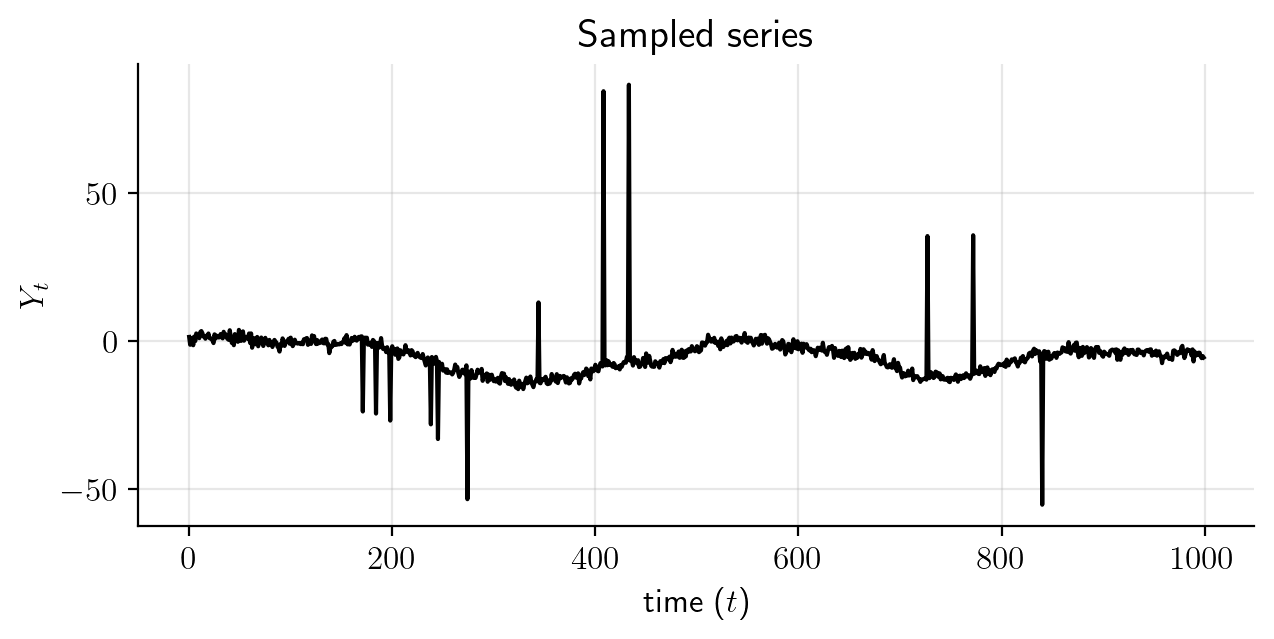

In [896]:
plt.plot(sample["y"], c="black", markersize=3)
plt.xlabel("time ($t$)")
plt.title("Sampled series")
plt.ylabel("$Y_t$")
plt.grid(alpha=0.3)

In [897]:
y = sample["y"]

Text(0.5, 0, 'num. observations')

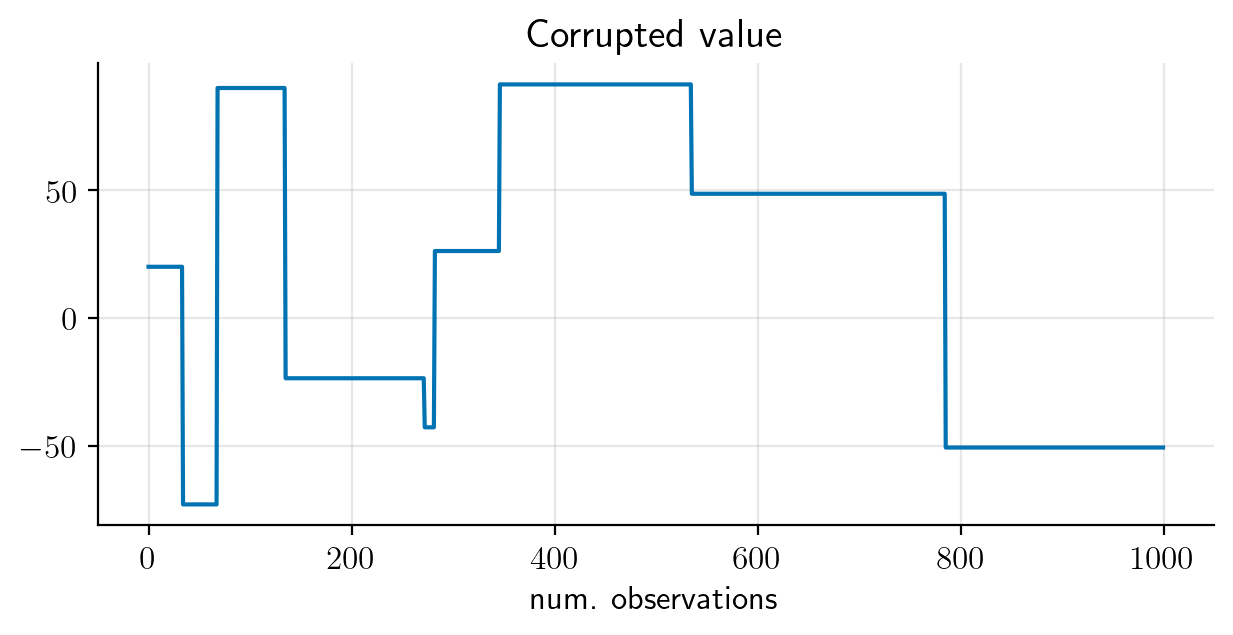

In [923]:
plt.plot(sample["corrupt"])
plt.title("Corrupted value")
plt.grid(alpha=0.3)
plt.xlabel("num. observations")

## The Kalman filter (with unknown R)

In [899]:
@chex.dataclass
class KFConfig:
    H: jax.Array
    F: jax.Array
    sigma_rho: float


@chex.dataclass
class KFState:
    mean: jax.Array
    cov: jax.Array
    rho: float
    log_weight: float

    @staticmethod
    def init(key, mean, cov, n_particles, rho):
        means = einops.repeat(mean, "m -> s m", s=n_particles)
        covs = einops.repeat(cov, "i j -> s i j", s=n_particles)
        rhos = jax.random.normal(key, (n_particles,)) * rho
        log_weights = jnp.repeat(-jnp.log(n_particles), n_particles)

        return KFState(
            mean=means, 
            cov=covs,
            rho=rhos,
            log_weight=log_weights
        )


@chex.dataclass
class KFStateSingle:
    mean: jax.Array
    cov: jax.Array


def kf_step(y, bel, cfg):
    """
    Update belief and compute log-posterior-predictive
    """
    # R = jnp.eye(1) * jnp.exp(bel.rho)
    R = jnp.eye(1) * r ** 2
    Q = jnp.eye(1) * q ** 2
    
    # Predict step
    mean_pred = cfg.F @ bel.mean
    cov_pred = cfg.F @ bel.cov @ cfg.F.T + Q

    # Innovation, variance, and Kalman gain
    yhat = cfg.H @ mean_pred
    
    err = y - yhat

    c = jnp.exp(bel.rho / 2)
    weight = 1 / jnp.exp(1 + jnp.power(err, 2) / c ** 2)

    St = cfg.H @ cov_pred @ cfg.H.T + R / weight
    Kt = jnp.linalg.solve(St, cfg.H @ cov_pred).T

    # Update step
    Kcov = jnp.eye(len(bel.mean)) - Kt @ cfg.H
    mean_update = mean_pred + Kt @ err
    cov_update = Kcov @ cov_pred @ Kcov.T + Kt @ R @ Kt.T

    bel = bel.replace(
        mean=mean_update,
        cov=cov_update
    )

    St_clean = cfg.H @ cov_pred @ cfg.H.T + R / weight
    log_pp = distrax.MultivariateNormalFullCovariance(yhat, St_clean).log_prob(y)

    return bel, log_pp, yhat


vkf_step_all = jax.vmap(kf_step, in_axes=(None, 0, 0, None))
vkf_step_B = jax.vmap(kf_step, in_axes=(None, 0, None, None))

# RBPF with transition as proposal

In [900]:
def stratified_resampling(key, log_weights, n_particles):
    """
    TODO: any way to work with log_weight only?
    """
    S = log_weights.shape[0]
    weights = jnp.exp(log_weights)
    cdf = jnp.cumsum(weights)
    # Generate n_particles stratified uniform samples in [0, 1)
    u = (jnp.arange(n_particles) + jax.random.uniform(key, shape=(n_particles,))) / n_particles
    indices = jnp.searchsorted(cdf, u)
    return indices


@partial(jax.vmap, in_axes=(0, None, 0, None))
def kf_rbpf_step(key, y, bel, cfg):
    """
    Draw a single sample from proposal p(psi(t) | psi(t,s)),
    update belief and compute log_posterior_predictive
    """
    rho_new = jax.random.normal(key) * cfg.sigma_rho + bel.rho
    bel = bel.replace(rho=rho_new)
    bel_update, log_pp, yhat = kf_step(y, bel, cfg)

    return bel_update, log_pp, yhat


def _resample(key, log_weights, bel):
    """
    Resample particles if the effective sample size (ESS)
    is below some threshold
    """
    # indices = jax.random.categorical(key, log_weights, shape=(n_particles,))
    indices = stratified_resampling(key, log_weights, n_particles)
    bel = jax.tree.map(lambda x: x[indices], bel)

    # Reset particles
    bel = bel.replace(
        log_weight=jnp.full(n_particles, -jnp.log(n_particles))
    )
    
    return bel


def _continue(key, log_weights, bel):
    bel = bel.replace(
        log_weight=log_weights
    )
    return bel


def step(bel, xs, cfg, pct_particles):
    y, key = xs
    key_propagate, key_resample = jax.random.split(key)
    keys = jax.random.split(key_propagate, n_particles)
    bel_update, log_pp, yhat_all = kf_rbpf_step(keys, y, bel, cfg)

    weights = jnp.exp(bel.log_weight - jax.nn.logsumexp(bel.log_weight))
    yhat = (yhat_all.squeeze() * weights).sum()

    log_weights = bel.log_weight + log_pp
    log_weights = log_weights - jax.nn.logsumexp(log_weights)
    ess = 1 / jnp.sum(jnp.exp(log_weights) ** 2)

    bel_update = jax.lax.cond(
        ess < n_particles * pct_particles,
        _resample,
        _continue,
        key_resample, log_weights, bel_update
    )

    return bel_update, (log_weights, bel_update.rho, bel_update.mean, yhat)

### Filter

In [901]:
n_particles = 300
config = KFConfig(
    H=H[None],
    F=jnp.eye(1),
    sigma_rho=0.1   
)


rho_init = jnp.log(5) + jax.random.normal(key_init_hparams, n_particles) 

In [902]:
dim_state = 1

In [903]:
mean_init = jnp.zeros(dim_state)
cov_init = jnp.eye(dim_state) * 1
keys = jax.random.split(key_eval, T)
bel_init = KFState.init(key_train, mean_init, cov_init, n_particles, rho_init)

Xs = (y[:,None], keys)
_step = partial(step, cfg=config, pct_particles=0.5)
bel_final, (hist_ll, hist_rho, hist_mean, yhat_hist) = jax.lax.scan(_step, bel_init, Xs)

In [904]:
log_weight = hist_ll - jax.nn.logsumexp(hist_ll, axis=1, keepdims=True)
weights = jnp.exp(log_weight)

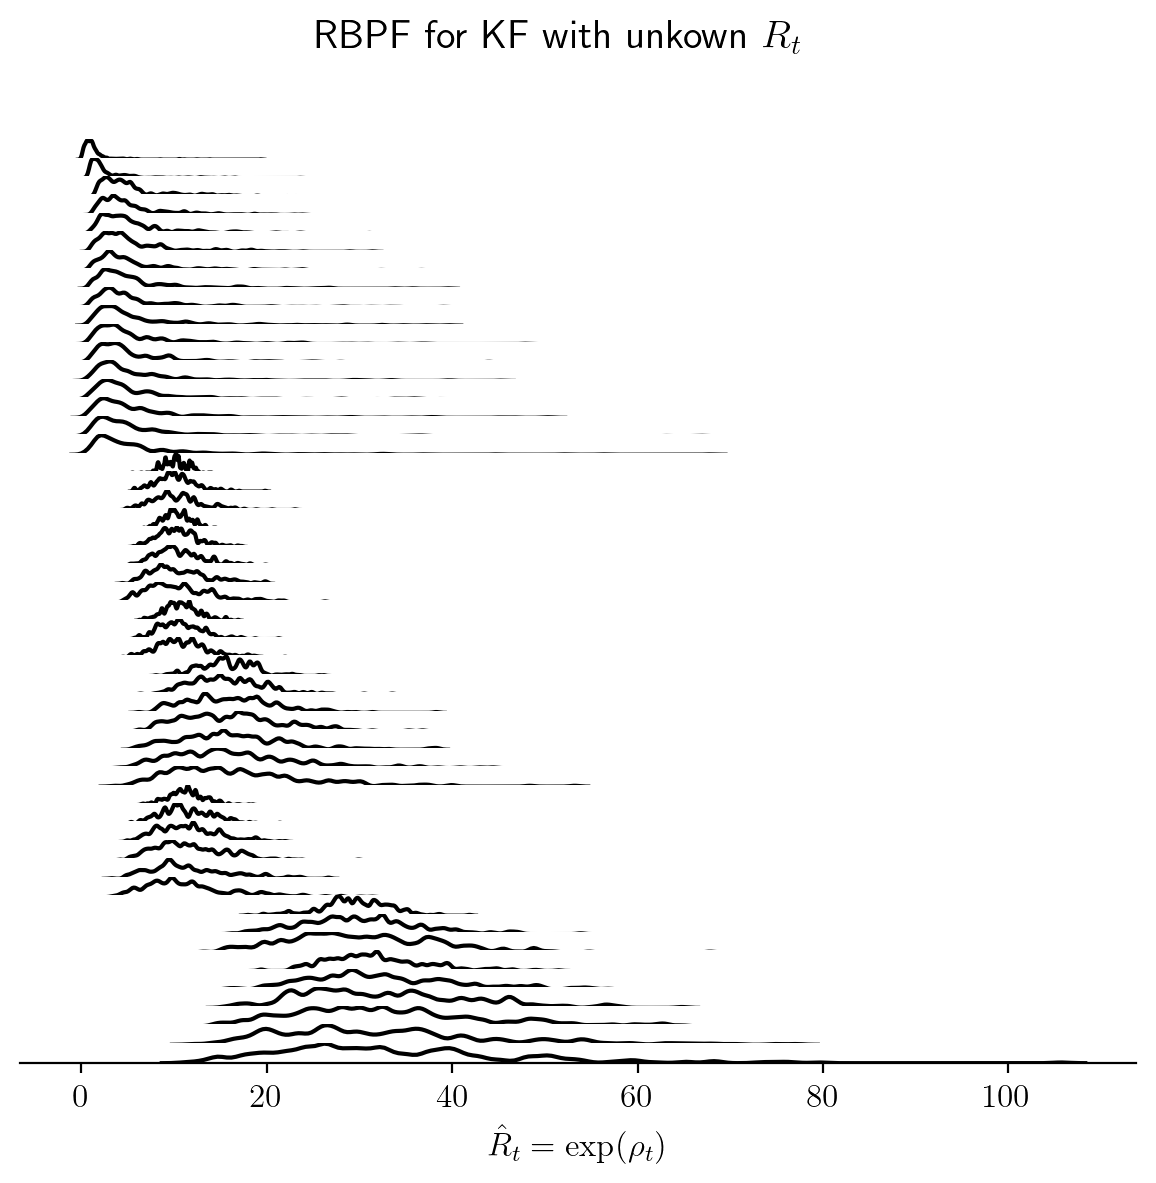

In [905]:
tvals = [1, 2, 5, 10, 15, 20, 25]
tvals = jnp.arange(1, 500, 10)
fig, axs = plt.subplots(len(tvals), 1, sharex=True, sharey=False, figsize=(7.2, 6.0))

for t, ax in zip(tvals, axs):
    sns.kdeplot(jnp.exp(hist_rho[t]/2), ax=ax, c="black", bw_adjust=0.2)
    ax.set_ylabel("")
    # ax.set_yscale('log')
    ax.set_yticks([])
    # ax.axis("off")
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # ax.set_xlim(left=0.1, right=1.5)
    # ax.set_xlim(left=0.2, right=2.0)
ax.spines["bottom"].set_visible(True)
ax.set_xlabel(r"$\hat{R}_t = \exp(\rho_t)$")
plt.suptitle("RBPF for KF with unkown $R_t$")
plt.subplots_adjust(hspace=-0.1)

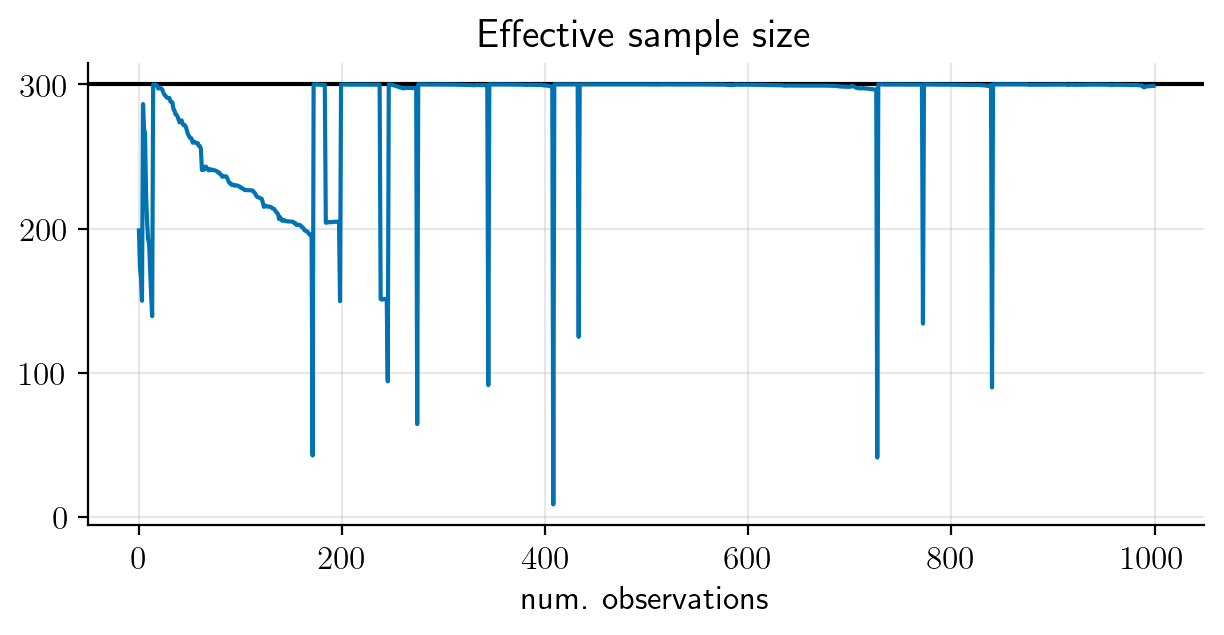

In [906]:
# Effective sample size
plt.title("Effective sample size")
plt.axhline(y=n_particles, c="black")
ess = 1 / jnp.sum(weights ** 2, axis=1)
plt.plot(ess)
plt.xlabel("num. observations")
plt.grid(alpha=0.3)

In [907]:
R_hist = jnp.exp(hist_rho / 2)
mean = (R_hist * weights).sum(axis=-1) / weights.sum(axis=-1)
var = (R_hist ** 2 * weights).sum(axis=-1) - (R_hist * weights).sum(axis=-1) ** 2

Text(0.5, 0, 'num. observations')

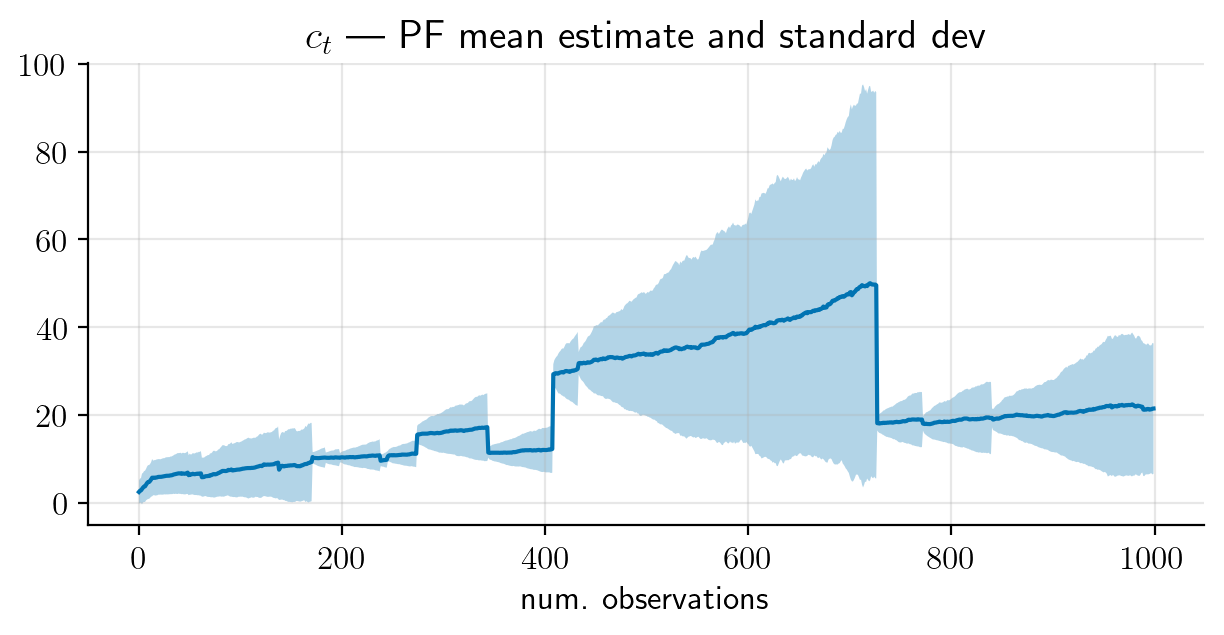

In [911]:
plt.fill_between(steps, mean -  jnp.sqrt(var), mean + jnp.sqrt(var), alpha=0.3)
# plt.axvline(x=n1, c="black", linestyle="--")
plt.plot(mean)
plt.grid(alpha=0.3)
# plt.title(r"$\mathbb{E}$")
# plt.axhline(y=Rtrue, c="black")
plt.title("$c_t$ — PF mean estimate and standard dev")
plt.xlabel("num. observations")

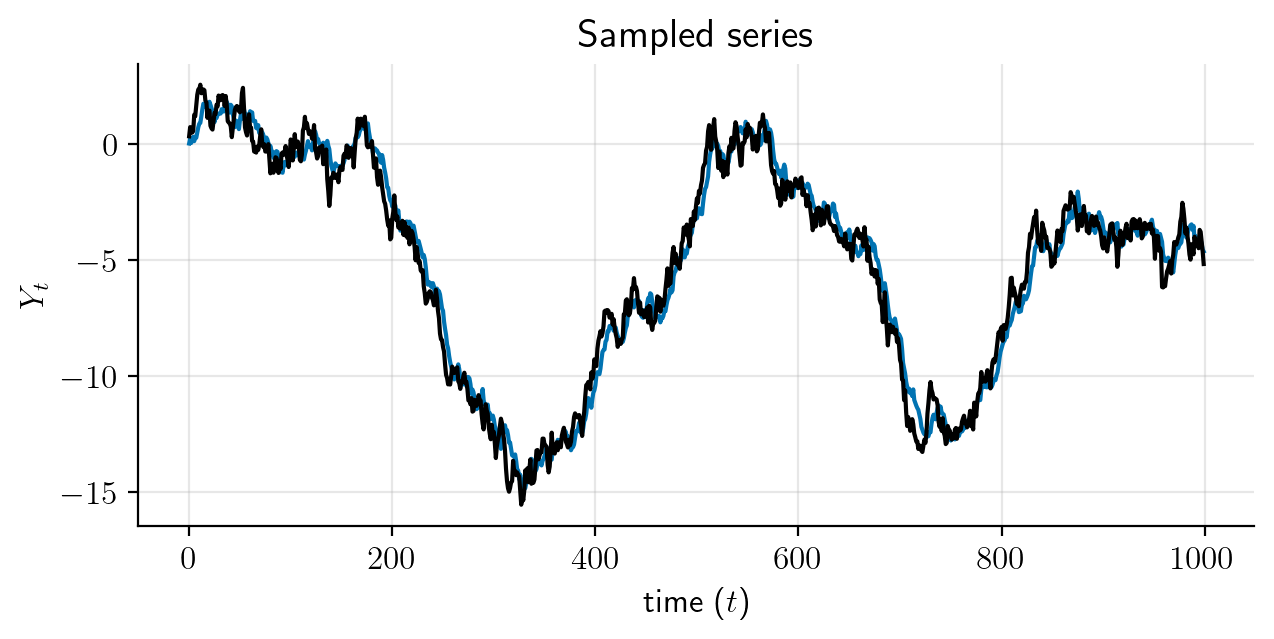

In [909]:
plt.plot(yhat_hist)
plt.plot(sample["theta"], c="black", markersize=3)
plt.xlabel("time ($t$)")
plt.title("Sampled series")
plt.ylabel("$Y_t$")
plt.grid(alpha=0.3)

## Single KF

In [912]:
@chex.dataclass
class KFStateSingle:
    mean: jax.Array
    cov: jax.Array


def kf_step_org(bel, y, cfg):
    """
    Update belief and compute log-posterior-predictive
    """
    # R = jnp.eye(1) * jnp.exp(bel.rho)
    R = jnp.eye(1) * r ** 2
    Q = jnp.eye(1) * q ** 2
    
    # Predict step
    mean_pred = cfg.F @ bel.mean
    cov_pred = cfg.F @ bel.cov @ cfg.F.T + Q

    # Innovation, variance, and Kalman gain
    yhat = cfg.H @ mean_pred
    
    err = y - yhat

    # c = jnp.exp(bel.rho / 2)
    c = 4.0
    weight = 1 / jnp.exp(1 + jnp.power(err, 2) / c ** 2)
    # weight = 1.0

    St = cfg.H @ cov_pred @ cfg.H.T + R / weight
    Kt = jnp.linalg.solve(St, cfg.H @ cov_pred).T

    # Update step
    Kcov = jnp.eye(len(bel.mean)) - Kt @ cfg.H
    mean_update = mean_pred + Kt @ err
    cov_update = Kcov @ cov_pred @ Kcov.T + Kt @ R @ Kt.T

    bel = bel.replace(
        mean=mean_update,
        cov=cov_update
    )

    log_pp = distrax.MultivariateNormalFullCovariance(yhat, St).log_prob(y)

    return bel, yhat


In [913]:
bel_init_single = KFStateSingle(mean=mean_init, cov=cov_init)
_step = partial(kf_step_org, cfg=config)
_, hist_kf = jax.lax.scan(_step, bel_init_single, y[:, None])

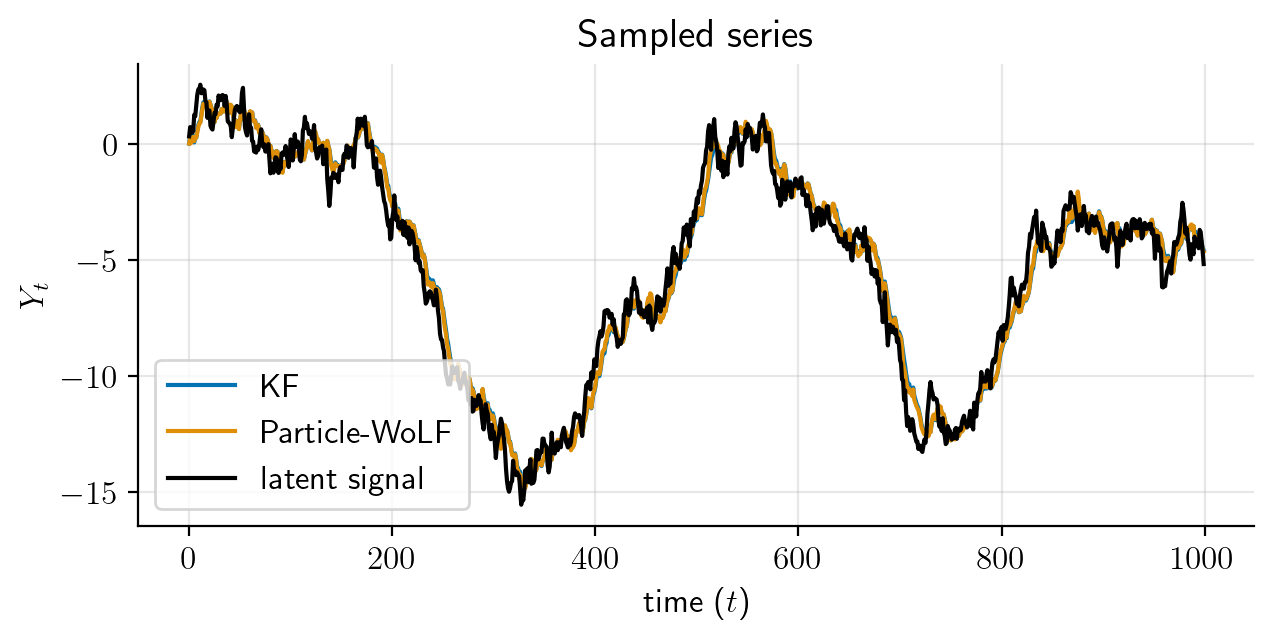

In [914]:
plt.plot(hist_kf, label="KF")
plt.plot(yhat_hist, label="Particle-WoLF")
plt.plot(sample["theta"], c="black", markersize=3, label="latent signal")
plt.xlabel("time ($t$)")
plt.title("Sampled series")
plt.ylabel("$Y_t$")
plt.legend()
plt.grid(alpha=0.3)

In [918]:
jnp.power(sample["theta"].ravel() - yhat_hist, 2).mean()

Array(0.5837862, dtype=float32)

In [919]:
jnp.power(sample["theta"].ravel() - hist_kf.ravel(), 2).mean()

Array(0.64714783, dtype=float32)